In [8]:
# Superpixel Segmentation with GNN for MRI using PyTorch Geometric

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage.color import rgb2gray
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from mpl_toolkits.mplot3d import Axes3D


In [9]:

# --- Configuration ---
BATCH_SIZE = 16
EPOCHS = 20
IMG_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 4


In [10]:

# --- Dataset Path ---
data_dir = "./data"

def preprocess_image(img_path, num_segments=75):
    image = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE)).convert('RGB')
    img = np.array(image)
    segments = slic(img_as_float(img), n_segments=num_segments, compactness=10, sigma=1, start_label=0)
    gray_img = rgb2gray(img)

    num_nodes = np.max(segments) + 1
    superpixels = torch.zeros((num_nodes, 1), dtype=torch.float)
    counts = torch.zeros((num_nodes,), dtype=torch.float)

    for i in range(segments.shape[0]):
        for j in range(segments.shape[1]):
            label = segments[i, j]
            superpixels[label] += gray_img[i, j]
            counts[label] += 1

    superpixels /= counts.unsqueeze(1)

    edge_index_set = set()
    for i in range(segments.shape[0] - 1):
        for j in range(segments.shape[1] - 1):
            curr = segments[i, j]
            right = segments[i, j + 1]
            down = segments[i + 1, j]
            if curr != right:
                edge_index_set.add((curr, right))
                edge_index_set.add((right, curr))
            if curr != down:
                edge_index_set.add((curr, down))
                edge_index_set.add((down, curr))

    edge_index = torch.tensor(list(edge_index_set), dtype=torch.long).t().contiguous()

    return superpixels, edge_index


In [11]:

# --- Dataset Loader ---
def create_graph_dataset(data_path):
    graph_list = []
    class_map = {}
    for i, label in enumerate(sorted(os.listdir(data_path))):
        class_map[label] = i
        for img_name in tqdm(os.listdir(os.path.join(data_path, label)), desc=label):
            img_path = os.path.join(data_path, label, img_name)
            x, edge_index = preprocess_image(img_path)
            y = torch.tensor([i], dtype=torch.long)
            graph = Data(x=x, edge_index=edge_index, y=y)
            graph_list.append(graph)
    return graph_list, class_map

train_graphs, label_map = create_graph_dataset(os.path.join(data_dir, "train"))
val_graphs, _ = create_graph_dataset(os.path.join(data_dir, "val"))

graph_train_loader = DataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
graph_val_loader = DataLoader(val_graphs, batch_size=BATCH_SIZE)


VeryMildDemented: 100%|██████████| 2240/2240 [18:29<00:00,  2.02it/s]


In [12]:

# --- GCN Model ---
class SuperpixelGCN(torch.nn.Module):
    def __init__(self, hidden_channels=64, num_classes=NUM_CLASSES):
        super(SuperpixelGCN, self).__init__()
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x


In [13]:

# --- Train + Evaluate ---
def train_eval(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    model.to(DEVICE)

    train_loss_list, val_acc_list = [], []
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for data in graph_train_loader:
            data = data.to(DEVICE)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss_list.append(total_loss / len(graph_train_loader))

        # Validation
        model.eval()
        correct, total = 0, 0
        preds, targets = [], []
        with torch.no_grad():
            for data in graph_val_loader:
                data = data.to(DEVICE)
                out = model(data)
                pred = out.argmax(dim=1)
                correct += int((pred == data.y).sum())
                total += len(data.y)
                preds.extend(pred.cpu().numpy())
                targets.extend(data.y.cpu().numpy())

        acc = correct / total
        val_acc_list.append(acc)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}, Val Accuracy: {acc:.4f}")

    # Charts
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121)
    ax.plot(train_loss_list, label="Training Loss")
    ax.set_title("Training Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(range(len(val_acc_list)), val_acc_list, zs=0, zdir='z', label='Validation Accuracy')
    ax2.set_title("Validation Accuracy in 3D")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_zlabel("Z-Axis")
    plt.legend()
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
    disp.plot(xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(targets, preds, target_names=list(label_map.keys())))

    # Save model
    torch.save(model.state_dict(), "superpixel_gnn_model.pth")
    print("Model saved as superpixel_gnn_model.pth")


Epoch 1/20, Loss: 2865.3634, Val Accuracy: 0.4830
Epoch 2/20, Loss: 2842.8672, Val Accuracy: 0.4750
Epoch 3/20, Loss: 2842.5432, Val Accuracy: 0.4728
Epoch 4/20, Loss: 2842.1571, Val Accuracy: 0.4892
Epoch 5/20, Loss: 2842.2535, Val Accuracy: 0.4806
Epoch 6/20, Loss: 2842.1041, Val Accuracy: 0.4767
Epoch 7/20, Loss: 2841.7243, Val Accuracy: 0.4889
Epoch 8/20, Loss: 2841.1975, Val Accuracy: 0.4827
Epoch 9/20, Loss: 2841.2023, Val Accuracy: 0.4330
Epoch 10/20, Loss: 2840.5690, Val Accuracy: 0.4755
Epoch 11/20, Loss: 2840.3582, Val Accuracy: 0.4369
Epoch 12/20, Loss: 2841.2508, Val Accuracy: 0.4936
Epoch 13/20, Loss: 2840.9800, Val Accuracy: 0.4733
Epoch 14/20, Loss: 2840.2863, Val Accuracy: 0.4834
Epoch 15/20, Loss: 2840.5851, Val Accuracy: 0.4422
Epoch 16/20, Loss: 2840.1946, Val Accuracy: 0.4606
Epoch 17/20, Loss: 2839.7482, Val Accuracy: 0.4830
Epoch 18/20, Loss: 2839.3740, Val Accuracy: 0.4623
Epoch 19/20, Loss: 2840.0807, Val Accuracy: 0.4772
Epoch 20/20, Loss: 2840.0694, Val Accura

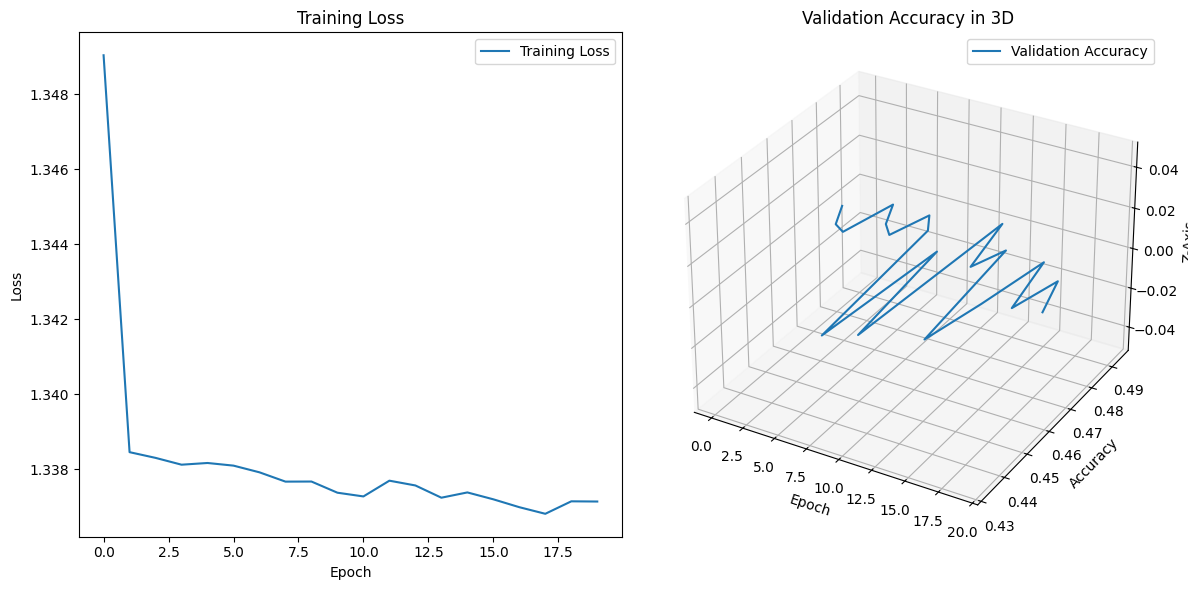

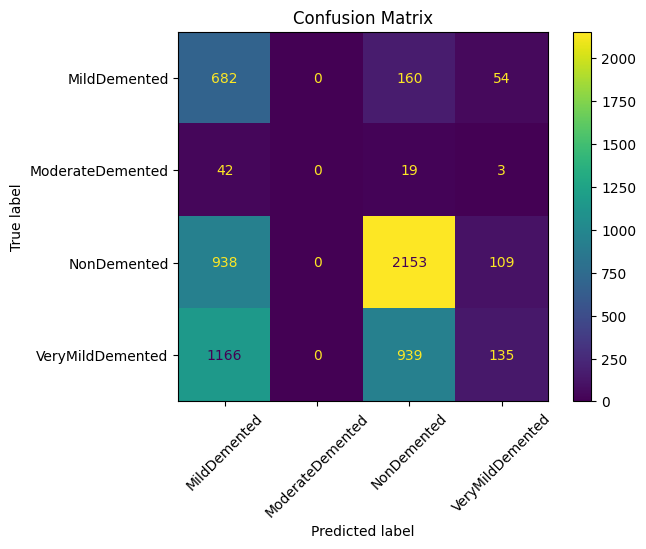

                  precision    recall  f1-score   support

    MildDemented       0.24      0.76      0.37       896
ModerateDemented       0.00      0.00      0.00        64
     NonDemented       0.66      0.67      0.67      3200
VeryMildDemented       0.45      0.06      0.11      2240

        accuracy                           0.46      6400
       macro avg       0.34      0.37      0.28      6400
    weighted avg       0.52      0.46      0.42      6400

Model saved as superpixel_gnn_model.pth


c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [14]:

# --- Run ---
if __name__ == "__main__":
    model = SuperpixelGCN()
    train_eval(model)
